# About

Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
File descriptions

    train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv  - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.


# Setup

In [16]:
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
from calendar import monthrange

import os
import pickle
import gc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBRegressor, plot_importance

from typing import List

In [3]:
# increase figure size
plt.rcParams["figure.figsize"] = (20, 10)

# disable scientific notation
pd.set_option('display.float_format', str)

In [62]:
# set this variable to True, if your local file structure is the same as on the kaggle notebook
run_on_kaggle = False

if run_on_kaggle:
    input_path = '/kaggle/input/'
    data_path = input_path + "competitive-data-science-predict-future-sales/"
    output_path = "output/"
else:
    input_path = '../data/'
    data_path = input_path
    output_path = "../output/"

In [63]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Data import

## train/test data

In [12]:
# train.csv - the training set. Daily historical data from January 2013 to October 2015.
train = pd.read_csv(data_path + "sales_train.csv")

# test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
test = pd.read_csv(data_path + "test.csv").set_index('ID')

## supplemental data

In [171]:
# items.csv - supplemental information about the items/products.
items = pd.read_csv(data_path + "items.csv")

# item_categories.csv  - supplemental information about the items categories.
item_categories = pd.read_csv(data_path + "item_categories.csv")

# shops.csv- supplemental information about the shops.
shops = pd.read_csv(data_path + "shops.csv")

## sample submission

In [172]:
# sample_submission.csv - a sample submission file in the correct format.
sample_submission = pd.read_csv(data_path + "sample_submission.csv")

# Exploratory data analysis

## basic statistics

### train data

In [173]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.0,1.0


In [174]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [175]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,14.56991146343017,33.001728290521754,10197.227056977385,890.8532326980126,1.242640885140891
std,9.42298770875573,16.226973048333605,6324.297353891169,1729.7996307126623,2.618834430895425
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


In [176]:
# number of items
train["item_id"].nunique()

21807

In [177]:
# number of shops
train["shop_id"].nunique()

60

In [178]:
# number of all possible combinations
train["shop_id"].nunique() * train["item_id"].nunique()

1308420

In [179]:
# check a certain item at a certain shop
train[(train["shop_id"] == 5) & (train["item_id"] == 5037)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1953995,21.09.2014,20,5,5037,2599.0,1.0
2150561,29.11.2014,22,5,5037,2599.0,1.0
2288630,28.12.2014,23,5,5037,1999.0,1.0
2288631,20.12.2014,23,5,5037,1999.0,1.0
2335446,02.01.2015,24,5,5037,1999.0,1.0
2335447,07.01.2015,24,5,5037,1999.0,1.0
2618926,29.05.2015,28,5,5037,1299.0,1.0
2704068,28.06.2015,29,5,5037,1499.0,1.0
2719247,05.07.2015,30,5,5037,1499.0,1.0
2810661,14.08.2015,31,5,5037,1499.0,1.0


### test data

In [180]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.0,1.0


In [181]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [182]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,14.56991146343017,33.001728290521754,10197.227056977385,890.8532326980126,1.242640885140891
std,9.42298770875573,16.226973048333605,6324.297353891169,1729.7996307126623,2.618834430895425
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


In [183]:
# number of items
test["item_id"].nunique()

5100

In [184]:
# number of shops
test["shop_id"].nunique()

42

In [185]:
# number of all possible combinations
test["shop_id"].nunique() * test["item_id"].nunique()

214200

We are missing several items and shops from the train data set...

In [186]:
# check a certain item at a certain shop
test[(test["shop_id"] == 5) & (test["item_id"] == 5037)]

,shop_id,item_id
ID,,
0,5,5037


In [187]:
# merge with the sample submission
pd.merge(test, sample_submission, on="ID")

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.5
1,1,5,5320,0.5
2,2,5,5233,0.5
3,3,5,5232,0.5
4,4,5,5268,0.5
...,...,...,...,...
214195,214195,45,18454,0.5
214196,214196,45,16188,0.5
214197,214197,45,15757,0.5
214198,214198,45,19648,0.5


### supplemental data

#### items

In [188]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [189]:
items["item_id"].nunique()

22170

There are too many different item names to really make use of them...

#### item categories

In [190]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Column `item_category_name` seems to consist of two categories separated by "-".

In [191]:
item_categories["item_category_name"].nunique()

84

#### shops

In [192]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


First part of `shop_name` is the city, second part the name of the actual shop.

In [193]:
# number of shops
shops["shop_name"].nunique()

60

## data per shop

Text(0.5, 1.0, 'Total sales per shop')

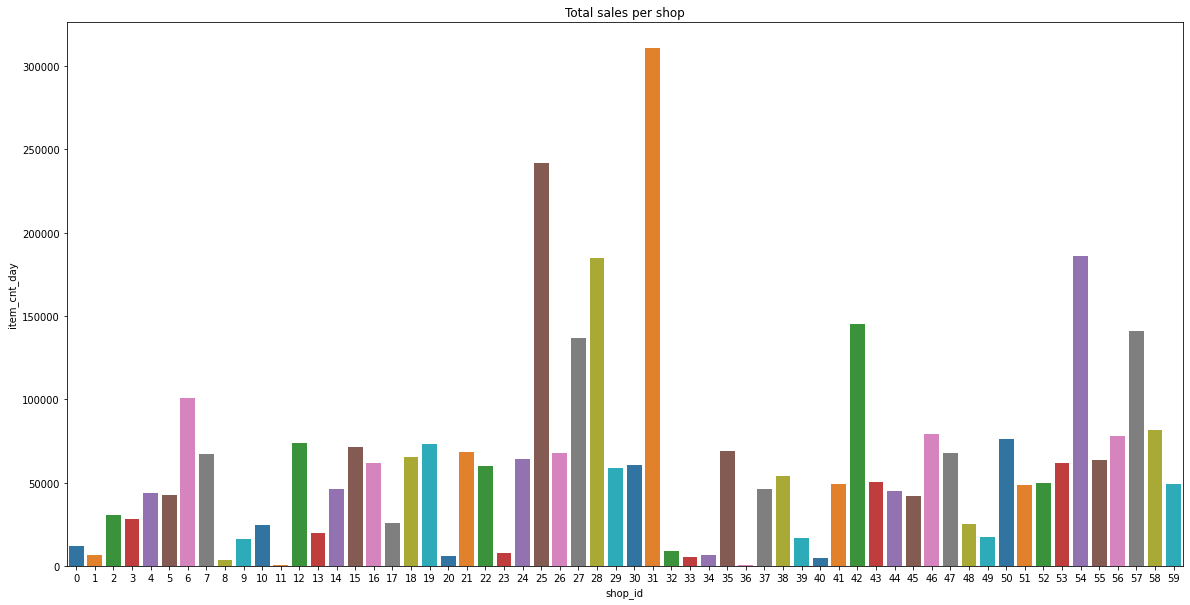

In [194]:
total_sales_per_shop = train.groupby("shop_id", as_index=False)["item_cnt_day"].sum()
sns.barplot(x="shop_id", y="item_cnt_day", data=total_sales_per_shop, palette="tab10").set_title("Total sales per shop")

Text(0.5, 1.0, 'Mean sales per shop')

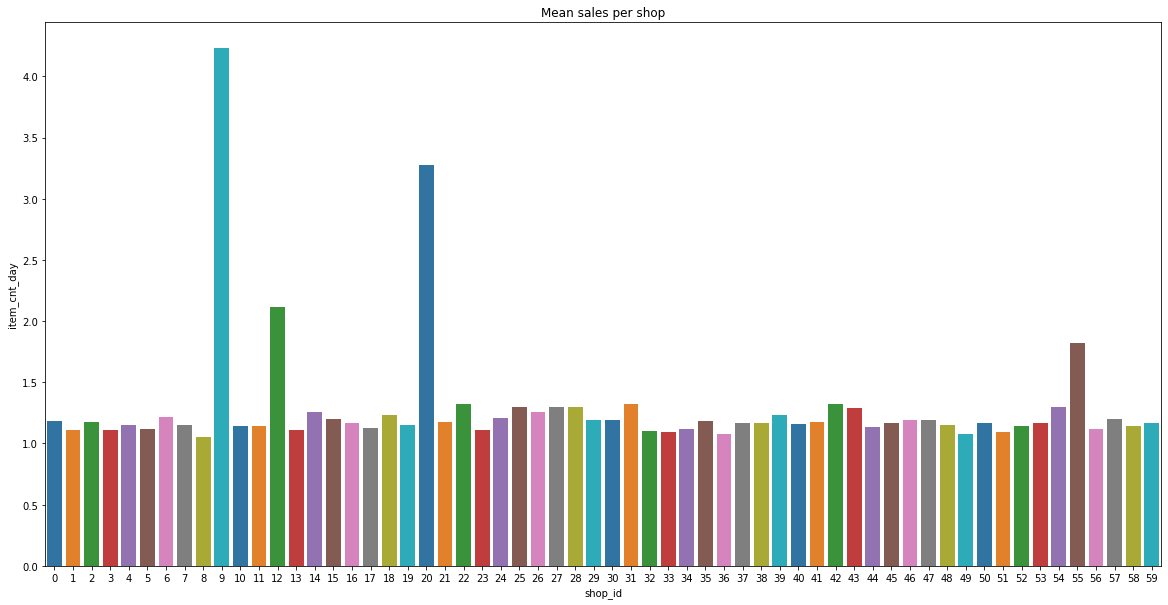

In [195]:
mean_sales_per_shop = train.groupby("shop_id", as_index=False)["item_cnt_day"].mean()
sns.barplot(x="shop_id", y="item_cnt_day", data=mean_sales_per_shop, palette="tab10").set_title("Mean sales per shop")

## data per month

Text(0.5, 1.0, 'Total sales per month')

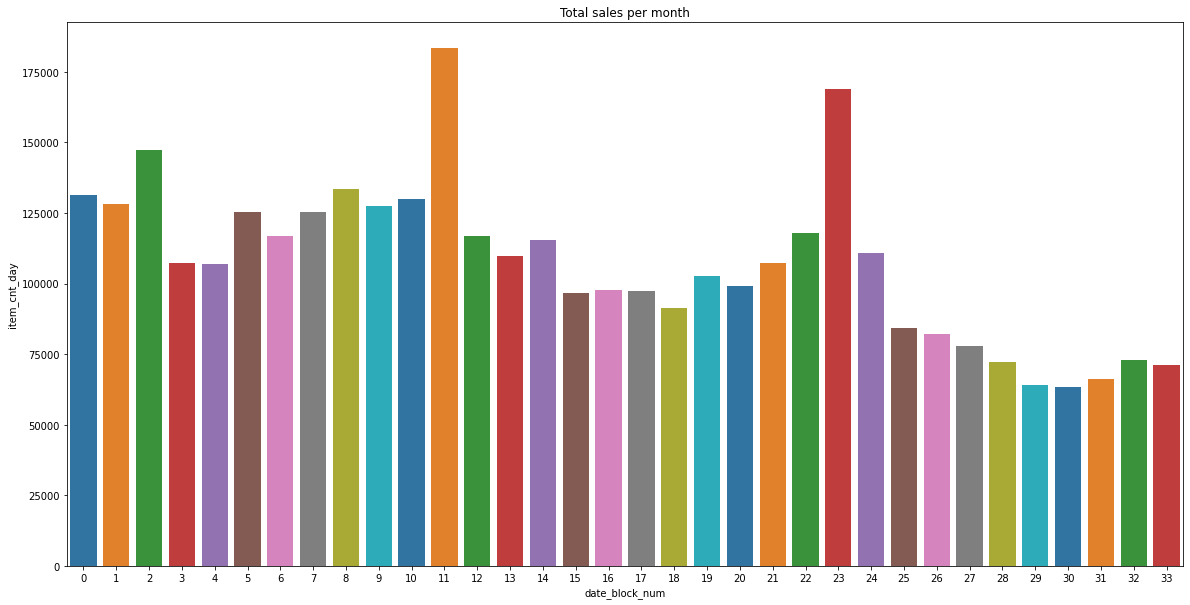

In [196]:
total_sales_per_month = train.groupby("date_block_num", as_index=False)["item_cnt_day"].sum()
sns.barplot(x="date_block_num", y="item_cnt_day", data=total_sales_per_month, palette="tab10").set_title("Total sales per month")

Text(0.5, 1.0, 'Total sales per month')

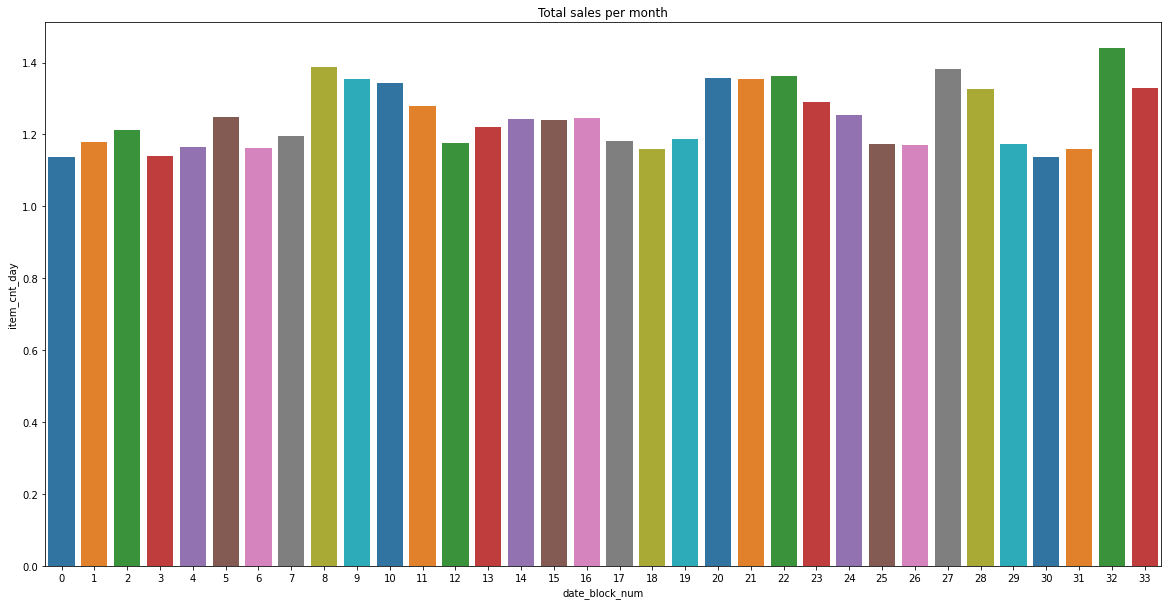

In [197]:
mean_sales_per_month = train.groupby("date_block_num", as_index=False)["item_cnt_day"].mean()
sns.barplot(x="date_block_num", y="item_cnt_day", data=mean_sales_per_month, palette="tab10").set_title("Total sales per month")

## Outliers

In [198]:
def check_for_outlier(series: pd.Series, lower_quantile: float = 0.05, upper_quantile: float = 0.95) -> None:
    """
    Checks for outliers by plotting and printing them.
    :param series: pd.Series, data to check
    :param lower_quantile: float, percentage of the lower quantile
    :param upper_quantile: float, percentage of the upper quantile
    :return: None
    """

    # describe the data
    display(series.describe())

    # plot the data
    sns.boxplot(x=series)
    plt.show()

    # plot with adjusted x axis
    lower_q = series.quantile(q=lower_quantile)
    upper_q = series.quantile(q=upper_quantile)
    plt.xlim(lower_q - 0.2, upper_q + 0.2)
    sns.boxplot(x=series)
    plt.show()

### item_price

count            2935849.0
mean     890.8532326980126
std     1729.7996307126623
min                   -1.0
25%                  249.0
50%                  399.0
75%                  999.0
max               307980.0
Name: item_price, dtype: float64

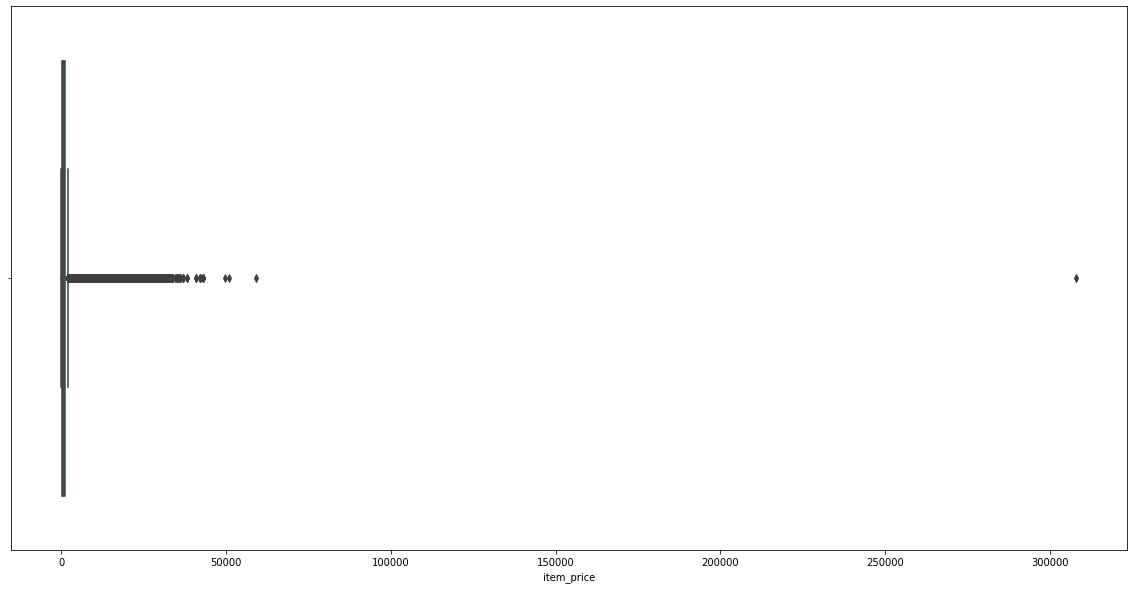

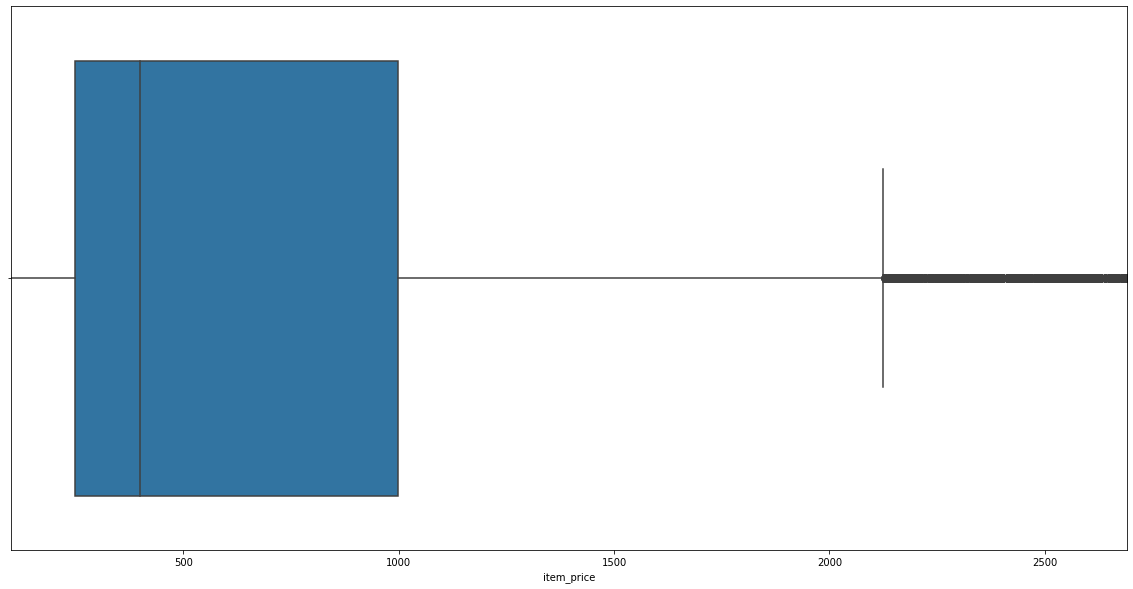

In [199]:
check_for_outlier(train["item_price"])

In [200]:
train[train["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


### item_cnt_day

In [201]:
train["item_cnt_day"].value_counts()

1.0       2629372
2.0        194201
3.0         47350
4.0         19685
5.0         10474
           ...   
251.0           1
501.0           1
112.0           1
164.0           1
2169.0          1
Name: item_cnt_day, Length: 198, dtype: int64

count           2935849.0
mean    1.242640885140891
std     2.618834430895425
min                 -22.0
25%                   1.0
50%                   1.0
75%                   1.0
max                2169.0
Name: item_cnt_day, dtype: float64

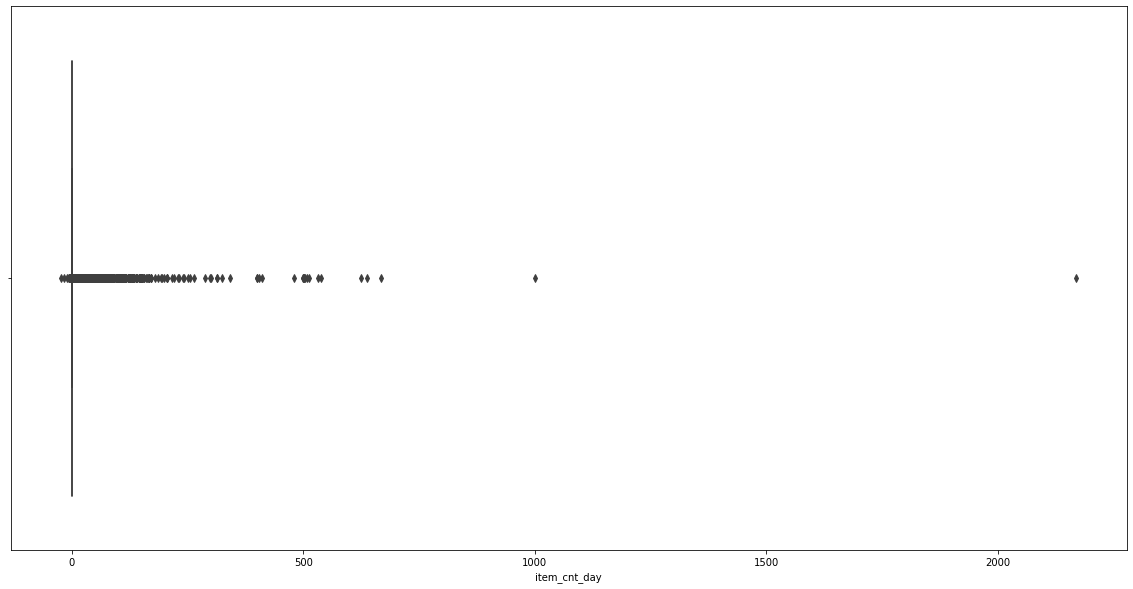

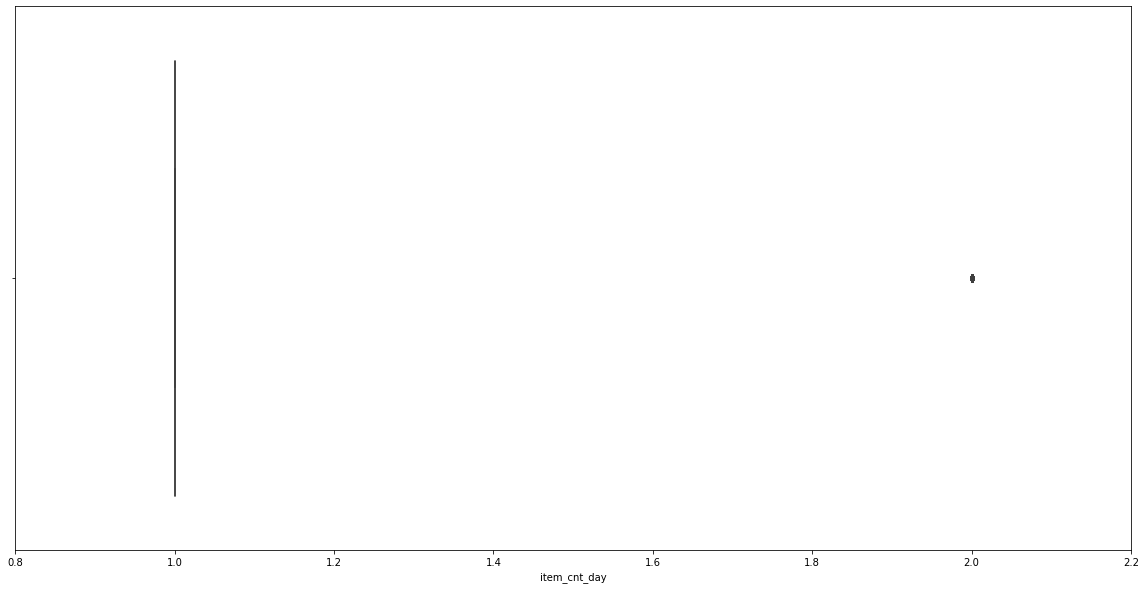

In [202]:
check_for_outlier(train["item_cnt_day"])

## Preprocessing

### clean data

In [203]:
# fix negative price with median
train.loc[train["item_price"] < 0, 'item_price'] = train["item_price"].median()

In [204]:
# filter outlier
train = train[train["item_price"] < 2000]
train = train[train["item_cnt_day"] < 250]

### Aggregate data
Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose. 
(Code based on Mean encodings assignment)

In [205]:
# Create "grid" with columns
index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)
grid = grid.sort_values(by=index_cols)

In [206]:
# Groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols, as_index=False).agg(item_cnt_month=('item_cnt_day', 'sum'))

all_data = pd.merge(grid, gb, how='left', on=index_cols)

# according to the submission file target data is clipped to [0, 20]
all_data["item_cnt_month"] = all_data["item_cnt_month"].fillna(0).clip(0, 20)

### add n_days for each month

In [210]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

In [211]:
def get_n_days(series):
    series["n_days"] = monthrange(series["date"].year, series["date"].month)[1]
    return series

In [213]:
n_days_per_month = (
    train.groupby(by="date_block_num", as_index=False).nth(0).apply(get_n_days, axis=1)[["date_block_num", "n_days"]]
)

In [215]:
all_data = pd.merge(all_data, n_days_per_month, how='left', on="date_block_num").fillna(0)

In [216]:
# test data set is month 34 from the train data set
test["date_block_num"] = 34
# november does have 30 days
test["n_days"] = 30

### add test data
We will use a time based split using month 33 as validation data and month 34 as test data

In [217]:
# test data set is month 34 from the train data set
test["date_block_num"] = 34

In [218]:
# add the test data
all_data = pd.concat([all_data, test], ignore_index=True, sort=False, keys=index_cols)
all_data = all_data.fillna(0)

### add supplemental data

#### items + item_categories

In [219]:
# item category name consists of a main category and a sub category
item_categories[["main_category", "sub_category"]] = item_categories["item_category_name"].str.split(" - ", expand=True)

In [220]:
item_categories['main_category'].nunique()

20

20 unique values is a bit too much for a One-Hot-Encoding, so we use a LabelEncoder instead...

In [221]:
item_categories["main_category_code"] = LabelEncoder().fit_transform(item_categories['main_category'])

In [222]:
item_categories['sub_category'].nunique()

60

Same for the sub_category...

In [223]:
item_categories["sub_category_code"] = LabelEncoder().fit_transform(item_categories['sub_category'])

In [224]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [225]:
# merge with the items
items_with_categories = pd.merge(items, item_categories, on="item_category_id", how="left")

# drop all columns containing strings
items_with_categories = items_with_categories.drop(["item_name", "item_category_name", 
                                                    "main_category", "sub_category"], axis=1)

In [226]:
# merge with the data
all_data = pd.merge(all_data, items_with_categories, on="item_id", how="left")

#### shops

In [227]:
# shop is <city shop_name>
shops["city"] = shops["shop_name"].apply(lambda x: x.split(" ")[0])

In [228]:
shops_with_categories = shops.copy()
shops_with_categories["city_code"] = LabelEncoder().fit_transform(shops_with_categories["city"])

# drop all columns containing strings
shops_with_categories = shops_with_categories.drop(["shop_name", "city"], axis=1)

In [229]:
# merge with the data
all_data = pd.merge(all_data, shops_with_categories, on="shop_id", how="left")

## advanced features

### target lags

In [230]:
def add_lag_features(df: pd.DataFrame, lag_months: List[int], col: str) -> pd.DataFrame:
    
    for lag_month in lag_months:
        train_shift = all_data[index_cols + [col]].copy()
        train_shift['date_block_num'] = train_shift['date_block_num'] + lag_month
        train_shift = train_shift.rename(columns={col: f'{col}_lag_{lag_month}'}) 
        df = pd.merge(df, train_shift, on=index_cols, how='left')
        
    return df

In [231]:
all_data = add_lag_features(df=all_data, lag_months=[1,2,3,6,12], col='item_cnt_month')

### Mean encoded features

#### average item_cnt per month

In [232]:
item_cnt_mean_per_month = (
    all_data.groupby(by=["date_block_num"], as_index=False).agg(item_cnt_mean_per_month=("item_cnt_month", "mean"))
)
all_data = pd.merge(all_data, item_cnt_mean_per_month, how="left", on=["date_block_num"])
all_data = add_lag_features(df=all_data, lag_months=[1], col='item_cnt_mean_per_month')
all_data = all_data.drop('item_cnt_mean_per_month', axis=1)

#### average item_cnt per month and item

In [233]:
item_cnt_mean_per_month_and_item = (
    all_data
    .groupby(by=["date_block_num", "item_id"], as_index=False)
    .agg(item_cnt_mean_per_month_and_item=("item_cnt_month", "mean"))
)
all_data = pd.merge(all_data, item_cnt_mean_per_month_and_item, how="left", on=["date_block_num", "item_id"])
all_data = add_lag_features(df=all_data, lag_months=[1,2,3,6,12], col='item_cnt_mean_per_month_and_item')
all_data = all_data.drop('item_cnt_mean_per_month_and_item', axis=1)

#### average item_cnt per month and shop

In [234]:
shop_mean_per_month = (
    all_data
    .groupby(by=["date_block_num", "shop_id"], as_index=False)
    .agg(shop_mean_per_month=("item_cnt_month", "mean"))
)
all_data = pd.merge(all_data, shop_mean_per_month, how="left", on=["date_block_num", "shop_id"])
all_data = add_lag_features(df=all_data, lag_months=[1,2,3,6,12], col='shop_mean_per_month')
all_data = all_data.drop('shop_mean_per_month', axis=1)

#### average item_cnt per month and item category

In [235]:
category_mean_per_month = (
    all_data
    .groupby(by=["date_block_num", "item_category_id"], as_index=False)
    .agg(category_mean_per_month=("item_cnt_month", "mean"))
)
all_data = pd.merge(all_data, category_mean_per_month, how="left", on=["date_block_num", "item_category_id"])
all_data = add_lag_features(df=all_data, lag_months=[1], col="category_mean_per_month")
all_data = all_data.drop("category_mean_per_month", axis=1)

#### average item_cnt per month, shop and item category

In [236]:
shop_and_category_mean_per_month = (
    all_data
    .groupby(by=["date_block_num", "shop_id", "item_category_id"], as_index=False)
    .agg(shop_and_category_mean_per_month=("item_cnt_month", "mean"))
)
all_data = pd.merge(all_data, shop_and_category_mean_per_month, how="left", 
                    on=["date_block_num", "shop_id", "item_category_id"])
all_data = add_lag_features(df=all_data, lag_months=[1], col="shop_and_category_mean_per_month")
all_data = all_data.drop("shop_and_category_mean_per_month", axis=1)

### Cleaning up
We can't calculate the lag features for the data younger than 12 months, so we exclude the data from the train set

In [237]:
# we can't calculate the lag features for the data younger than the max_lag_month, so we exclude the data from the 
# train set
# max_lag_month = max(lag_months)
all_data = all_data[all_data["date_block_num"] > 11]

In [238]:
all_data = all_data.fillna(0)

In [239]:
# save data to file
all_data.to_pickle(f"{input_path}all_data.pkl")

In [240]:
# free memory by deleting the large data frames
del train
del grid
del all_data
gc.collect();

# Model training

In [5]:
data = pd.read_pickle(f"{input_path}all_data.pkl")

In [6]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'n_days',
       'item_category_id', 'main_category_code', 'sub_category_code',
       'city_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_mean_per_month_lag_1',
       'item_cnt_mean_per_month_and_item_lag_1',
       'item_cnt_mean_per_month_and_item_lag_2',
       'item_cnt_mean_per_month_and_item_lag_3',
       'item_cnt_mean_per_month_and_item_lag_6',
       'item_cnt_mean_per_month_and_item_lag_12', 'shop_mean_per_month_lag_1',
       'shop_mean_per_month_lag_2', 'shop_mean_per_month_lag_3',
       'shop_mean_per_month_lag_6', 'shop_mean_per_month_lag_12',
       'category_mean_per_month_lag_1',
       'shop_and_category_mean_per_month_lag_1'],
      dtype='object')

In [7]:
# unfortunately those features did not lead to a better performance, so we drop them
data = data.drop(["city_code", "main_category_code", "sub_category_code"], axis=1)

## train test split

Validation strategy is month 33 for the validation, month 34 for the test set and the rest for the train set.

In [8]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [9]:
# free memory
del data
gc.collect();

## XGBoost hyperparameter optimization

In [24]:
params = {
    "max_depth": [6, 8],
    "learning_rate": [0.1, 0.3, 0.5],
    "n_estimators": [500, 1000, 2000],
    "colsample_bytree": [0.3, 0.7],
    "learning_rate": [0.1, 0.3, 0.5],
}

In [56]:
xgbr = XGBRegressor(tree_method="gpu_hist", colsample_bytree=0.8, subsample=0.8, eval_metric="rmse", 
                    early_stopping_rounds=10)

In [57]:
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   cv=2,
                   error_score="raise",
                   verbose=3)
clf.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=False)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.655 total time=  24.0s
[CV 2/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.733 total time=  16.4s
[CV 1/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.655 total time=  21.7s
[CV 2/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.733 total time=  16.8s
[CV 1/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=2000;, score=-0.655 total time=  19.8s
[CV 2/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=2000;, score=-0.733 total time=  17.6s
[CV 1/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=8, n_estimators=500;, score=-0.656 total time=  26.7s
[CV 2/2] END colsample_bytree=0.3, learning_rate=0.1, max_depth=8, n_estimators=500;, score=-0.725 total time

[CV 2/2] END colsample_bytree=0.7, learning_rate=0.5, max_depth=8, n_estimators=1000;, score=-0.747 total time=  13.7s
[CV 1/2] END colsample_bytree=0.7, learning_rate=0.5, max_depth=8, n_estimators=2000;, score=-0.680 total time=  15.1s
[CV 2/2] END colsample_bytree=0.7, learning_rate=0.5, max_depth=8, n_estimators=2000;, score=-0.747 total time=  14.3s
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
Lowest RMSE:  0.826176579008127


In [58]:
print(f"best params: {clf.best_params_}")
print(f"lowest RMSE: {(-clf.best_score_)**(1/2)}")

best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
lowest RMSE: 0.826176579008127


## XGBoost Model Training

In [59]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=500,
    min_child_weight=300, 
    colsample_bytree=0.7, 
    subsample=0.8, 
    learning_rate=0.1,    
    tree_method="gpu_hist",
    early_stopping_rounds=25,
    eval_metric="rmse")

model.fit(
    X_train, 
    Y_train, 
    verbose=True, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    )

[0]	validation_0-rmse:1.08264	validation_1-rmse:1.05071
[1]	validation_0-rmse:1.04014	validation_1-rmse:1.02061
[2]	validation_0-rmse:1.00474	validation_1-rmse:0.99556
[3]	validation_0-rmse:0.97477	validation_1-rmse:0.97536
[4]	validation_0-rmse:0.94941	validation_1-rmse:0.95841
[5]	validation_0-rmse:0.92809	validation_1-rmse:0.94407
[6]	validation_0-rmse:0.90934	validation_1-rmse:0.93148
[7]	validation_0-rmse:0.89349	validation_1-rmse:0.92122
[8]	validation_0-rmse:0.88111	validation_1-rmse:0.91365
[9]	validation_0-rmse:0.86973	validation_1-rmse:0.90606
[10]	validation_0-rmse:0.86001	validation_1-rmse:0.89979
[11]	validation_0-rmse:0.85180	validation_1-rmse:0.89488
[12]	validation_0-rmse:0.84465	validation_1-rmse:0.89053
[13]	validation_0-rmse:0.83887	validation_1-rmse:0.88690
[14]	validation_0-rmse:0.83383	validation_1-rmse:0.88424
[15]	validation_0-rmse:0.82941	validation_1-rmse:0.88154
[16]	validation_0-rmse:0.82574	validation_1-rmse:0.87942
[17]	validation_0-rmse:0.82271	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=25, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [67]:
# save the model
model.save_model(f'{output_path}xgb_model.json')

## create submission

In [75]:
# load the trained model
trained_model = XGBRegressor()
trained_model.load_model(f'{output_path}xgb_model.json')

In [64]:
Y_test = trained_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv(f'{output_path}xgb_submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

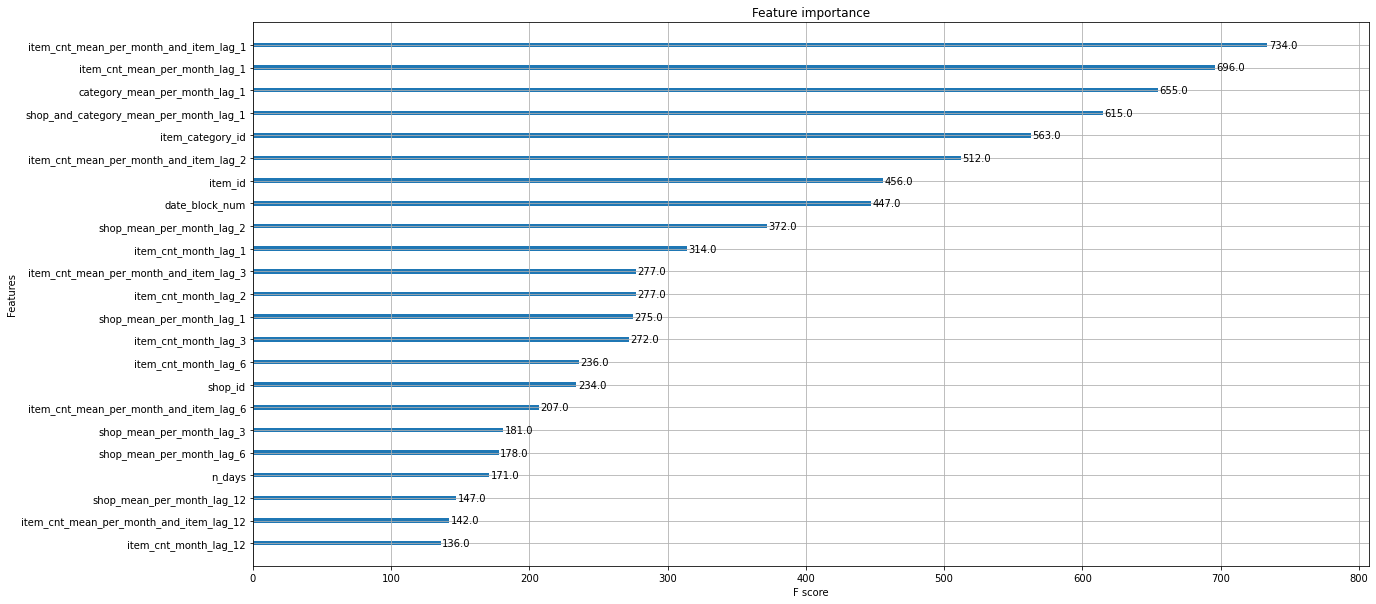

In [65]:
plot_importance(booster=model)